In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import uproot
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, TreeMakerSchema

import pickle
import glob

ak.behavior.update(candidate.behavior)


# # a = ak.flatten(llp.z[ak.any(ClusterID,axis=1)])
# <Array [908, -694, 859, ... -1.07e+03, -974] type='15 * float32'>
# b = ak.flatten(llp.z)
# <Array [621, 908, -721, ... -1.07e+03, -974] type='63 * float32'>
# ak.flatten(ak.fill_none(ak.mask(llp.z,ak.any(ClusterID,axis=1)),[0]))
# <Array [0, 908, 0, 0, ... 0, -1.07e+03, -974] type='63 * float64'>

def maskAndFill(denom,selection,value):
    numer = ak.mask(denom,selection)
    numer = ak.fill_none(numer, value) #fill none with same structure
    return ak.flatten(numer)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nCscRechits": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("nCscRechits", "nCscRechits", 50, 0, 1000),
            ),
            "nCluster": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("nCluster", "nCluster", 4, 0, 4),
            ),                   
            "ClusterSize": hist.Hist("Events",hist.Cat("dataset", "Dataset"),   
                hist.Bin('cutFlow','cutFlow',8,0,8),
                hist.Bin("ClusterSize", "ClusterSize", 50, 0, 2000),
            ),                
            "ClusterNChamber": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("ClusterNChamber", "ClusterNChamber", 10, 0, 10),
            ),                   
            "ClusterMaxChamber": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterMaxChamber", "ClusterMaxChamber", 80, 0, 40),
            ),                   
            "ClusterNStation10": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterNStation10", "ClusterNStation10", 10, 0, 10),
            ),                   
            "ClusterMaxStation": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterMaxStation", "ClusterMaxStation", 10, 0, 10),
            ),
            "ClusterAvgStation10": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterAvgStation10", "ClusterAvgStation10", 40, 0, 10),
            ),
            "ClusterME11_ME12": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterME11_ME12", "N_{ME11/ME12} hits", 50, 0, 50),
            ),            
            "ClusterEta": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterEta", "ClusterEta", 50, 0, 3),
            ),
            "ClusterTime": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterTime", "ClusterTime", 50, -80, 80),
            ),        
            "ClusterTimeSpread": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterTimeSpread", "ClusterTimeSpread", 80, 0, 80),
            ),            
            "clusterID":hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("Eta", "ClusterEta", 50, 0, 3),
                hist.Bin("AvgStation10", "ClusterAvgStation10", 20, 0, 5),                    
            ),            
            "clusterDecay":hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("length", "distance between LLP and cluster[cm]", 50, 0, 200),
                hist.Bin("llp_z", "LLP decay Z[cm]", 40, 570, 1050),                    
                hist.Bin("cluster_z", "cluster Z[cm]", 40, 570, 1050),                                                         
            ), 
            "llp":hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("selection",'pass/fail', 2,0,2),
                hist.Bin("z", "LLP decay Z[cm]", 40, 570, 1050),
                hist.Bin("r", "LLP decay R[cm]", 20, 100, 700),
                hist.Bin("e", "LLP E[GeV]", 20, 0, 250),
                hist.Bin("EMfrac", "LLP EM energy fraction", 40, 0, 1),                            
            ),
            'Veto':hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("muVeto", "muVeto", 2, 0, 2),
                hist.Bin("jetVeto", "jetVeto", 2, 0, 2),                             
            ),
            'muVeto':hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("pt"      , "muVeto_pt", 40, 0, 100),
                hist.Bin("time"    , "ClusterTime", 50, -80, 80),                               
                hist.Bin("eta"     , "muVeto_eta", 20, 0, 3),                 
                hist.Bin("LooseIso", "muVeto_LooseIso", 2, 0, 2),
                hist.Bin("LooseId", "muVeto_LooseId", 2, 0, 2),                               
                hist.Bin("TightId", "muVeto_TightId", 2, 0, 2),                                                              
            ),
            'jetVeto':hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("pt"      , "jetVeto_pt", 40, 0, 100),
                hist.Bin("eta"     , "jetVeto_eta", 20, 0, 3),
            ),            
            
            "nLeptons": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("nLeptons", "nLeptons", 5, 0, 5),
            ),            
            "lepPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("lepPt", "lepPt", 40, 0, 100),
            ), 
            "lepEta": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("lepEta", "lepEta", 40, -3, 3),
                hist.Bin('cutFlow','cutFlow',8,0,8),                                
            ),             
            "nJets": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("nJets", "nJets", 5, 0, 5),
            ),
            "jetPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("jetPt", "jetPt", 50, 50, 300),
            ),          
            "jetMet_dPhi": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("jetMet_dPhi", "jetMet_dPhi", 50, -np.pi, np.pi),
            ),  
            
            "metXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("metXYCorr", "metXYCorr", 50, 0, 500),
            ),            
            "metPhiXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("metPhiXYCorr", "metPhiXYCorr", 50, -np.pi, np.pi),
            ),
            "MT": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("MT", "MT", 50, 0, 200),
            ),            
            "dphi_cluster_MET": hist.Hist("Events",hist.Cat("dataset", "Dataset"),       
                hist.Bin('cutFlow','cutFlow',8,0,8),                                          
                hist.Bin("dphi_cluster_MET", r'$\Delta\phi$(cluster,MET)', 50, 0, np.pi),
            ),        
            "dphi_cluster_lep": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin('cutFlow','cutFlow',8,0,8),                                          
#                 hist.Bin('llp_matched','cls_llp_matched',2,0,2),
                hist.Bin("dphi", r'$\Delta\phi$(cluster,lep)', 50, 0, np.pi),
            ),
            "gLLP_csc": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_csc", 'gLLP_csc', 2, 0,2),
            ),                                
            "gWPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gWPt", 'gWPt', 50, 0,100),
            ),                    
            "glepdPhi": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_lepdPhi", r'$\Delta\phi$(gLLPp,g_lep)', 50, -np.pi,np.pi),
            ),                    
            "gLepPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLepPt", 'gLepPt', 50, 0,100),
            ),                    
            "gLLP_pt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_pt", 'gLLP_pt', 50, 0,100),
            ),                                            
            
            
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']        
        
        start,stop = events._branchargs['entry_start'],events._branchargs['entry_stop']
        events = uproot.lazy(events._tree)
        events = events[start:stop]
        
#         print('dataset=',dataset,' start,stop=(%s,%s)'%(start,stop))
        
        isSignal= ak.any(events.gLLP_csc)        
        isData = not(ak.any(events.gParticleE) or ak.any(events.gLepE))
        
        if isSignal:        
            ctau_old = 100
            ctau_new = 10
            w = (ctau_old/ctau_new)* exp(events.gLLP_ctau
            csc = ak.any(events.gLLP_csc,axis=1)
            w
            events = events[(csc==1)]
        
        llp=ak.zip({
            'pt':events.gLLP_pt,
            'EMfrac':events.gLLP_EMFracE,
            'e':events.gLLP_e,
            'z':events.gLLP_decay_vertex_z ,
            'r':events.gLLP_decay_vertex_r,
        })  
                   
        lep=ak.zip({
            'pt':events.lepPt ,
            'eta':events.lepEta,
            'phi':events.lepPhi,
            'energy':events.lepE,
            'pdgid':events.lepPdgId,
        },with_name='PtEtaPhiELorentzVector',
        behavior=vector.behavior    
        )  
            
        ele   = lep[abs(lep.pdgid)==11]
        muons = lep[abs(lep.pdgid)==13]
        
        
        cluster= ak.zip(
            {                
                "time":events.cscRechitCluster3Time,
                "size":events.cscRechitCluster3Size,                
                "timeSpread":events.cscRechitCluster3TimeSpread,
                "eta":events.cscRechitCluster3Eta,
                "phi":events.cscRechitCluster3Phi,
                "x":events.cscRechitCluster3X,
                "y":events.cscRechitCluster3Y,
                "z":events.cscRechitCluster3Z,                
                'llp_x':events.cscRechitCluster3_match_gLLP_decay_x,
                'llp_y':events.cscRechitCluster3_match_gLLP_decay_y,
                'llp_z':events.cscRechitCluster3_match_gLLP_decay_z,                 
                "NChamber":events.cscRechitCluster3NChamber,
                "MaxChamber":events.cscRechitCluster3MaxChamber,
                "MaxStation":events.cscRechitCluster3MaxStation,
                "NStation10":events.cscRechitCluster3NStation10,
                "AvgStation10":events.cscRechitCluster3AvgStation10,
                "ME11_12":(events.cscRechitCluster3Me11Ratio+events.cscRechitCluster3Me12Ratio)*events.cscRechitCluster3Size,                
                "llp_match":events.cscRechitCluster3_match_gLLP,
                "RE12":events.cscRechitCluster3_match_RE12_0p4,
                "MB1seg":events.cscRechitCluster3_match_MB1Seg_0p4,
                "RB1":events.cscRechitCluster3_match_RB1_0p4,
                "dphi_cluster_MET":events.cscRechitCluster3MetXYCorr_dPhi,                
            }
        )
        
        muVeto=ak.zip({
            'e':events.cscRechitCluster3MuonVetoE,
            "time":events.cscRechitCluster3Time,            
            'pt':events.cscRechitCluster3MuonVetoPt,
            'phi':events.cscRechitCluster3MuonVetoPhi,
            'eta':events.cscRechitCluster3MuonVetoEta,
            'LooseIso':events.cscRechitCluster3MuonVetoLooseIso,
            'LooseId':events.cscRechitCluster3MuonVetoLooseId,    
            'TightId':events.cscRechitCluster3MuonVetoTightId,
        })      

        jetVeto=ak.zip({
            'e':events.cscRechitCluster3JetVetoE,
            'pt':events.cscRechitCluster3JetVetoPt,
            'phi':events.cscRechitCluster3JetVetoPhi,
            'eta':events.cscRechitCluster3JetVetoEta,
        })           
        
        
        
        output["nLeptons"].fill(dataset=dataset,nLeptons=events.nLeptons)
        output["lepPt"].fill(dataset=dataset,lepPt=ak.flatten(events.lepPt))        
        output["nJets"].fill(dataset=dataset,nJets=events.nJets)
        output["jetPt"].fill(dataset=dataset,jetPt=ak.flatten(events.jetPt)) 
        output["jetMet_dPhi"].fill(dataset=dataset,jetMet_dPhi=events.jetMet_dPhi)         
        output["metXYCorr"].fill(dataset=dataset,metXYCorr=events.metXYCorr)        
        output["metPhiXYCorr"].fill(dataset=dataset,metPhiXYCorr=events.metPhiXYCorr)          
        output["gLLP_csc"].fill(dataset=dataset,gLLP_csc=ak.flatten(events.gLLP_csc))        
        output["gWPt"].fill(dataset=dataset,gWPt=events.gWPt)
        output["glepdPhi"].fill(dataset=dataset,gLLP_lepdPhi=ak.flatten(events.gLLP_lepdPhi))        
        output["gLLP_pt"].fill(dataset=dataset,gLLP_pt=ak.flatten(events.gLLP_pt))                
        output["gLepPt"].fill(dataset=dataset,gLepPt=events.gLepPt)                
        output["MT"].fill(dataset=dataset,MT=events.MT)
        

        

     
        
        
        ClusterID =((cluster.NStation10>1) & (abs(cluster.eta)<1.9))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==4) & (abs(cluster.eta)<1.8))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==3) & (abs(cluster.eta)<1.6))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==2) & (abs(cluster.eta)<1.6))
        
        muonVeto_mask = ~((muVeto.pt>20) & abs(muVeto.eta<2.4))
        jetVeto_mask  = ~((jetVeto.pt>10)& abs(jetVeto.eta<2.4))
        RE12_veto    = (cluster.RE12==0)
        MB1seg_veto  = (cluster.MB1seg==0)
        RB1_veto     = (cluster.RB1==0)
        ME11_12_veto = (cluster.ME11_12==0)
        if isData:
            timeCut      = (cluster.time < -12.5) #OOT for data
        else:
            timeCut      = (cluster.time < 12.5) & (cluster.time>-5) ## In-time otherwise        
        timeSpreadCut= (cluster.timeSpread<20)        
        
        cuts = [
            jetVeto_mask,
            muonVeto_mask,            
            ME11_12_veto,
            ((MB1seg_veto) & (RB1_veto)),
            timeCut,
            timeSpreadCut,
            ClusterID,
        ]
        cluster_dir= ak.zip(
        {
                'pt':ak.ones_like(events.cscRechitCluster3Eta),
                "eta":events.cscRechitCluster3Eta,
                "phi":events.cscRechitCluster3Phi,
                'mass':ak.zeros_like(events.cscRechitCluster3Eta)
            },with_name="PtEtaPhiMLorentzVector",
            behavior=vector.behavior
        )
        
        cls_lep_pair = ak.cartesian({"cls":cluster_dir,'lep':lep},axis=1,nested=True)
        dphi_lep_cls = cls_lep_pair.cls.delta_phi(cls_lep_pair.lep)        
        
        output["dphi_cluster_MET"].fill(dataset=dataset,
                                        cutFlow=0,
                                        dphi_cluster_MET=np.abs(ak.flatten(cluster.dphi_cluster_MET)))                
        #Matched component
        output["dphi_cluster_lep"].fill(dataset=dataset,
                cutFlow=0,
                dphi =abs(ak.flatten(dphi_lep_cls,axis=None))
        )
        #unmatched component
#         output["dphi_cluster_lep"].fill(dataset=dataset,
#                 cutFlow=0,
#                 llp_matched=ak.zeros_like(ak.flatten(dphi_lep_cls[~cluster.llp_match],axis=None)),
#                 dphi =abs(ak.flatten(dphi_lep_cls[~cluster.llp_match],axis=None))
#         )        
           
            
        allcuts = cuts[0]
        output["ClusterSize"].fill(dataset=dataset,
                                       cutFlow=0,ClusterSize=ak.flatten(cluster.size))        
        output["lepEta"].fill(dataset=dataset,
                                       cutFlow=0,lepEta=ak.flatten(lep.eta))                
        for i,cut in enumerate(cuts):
            allcuts = (allcuts & cut)                
            any_cluster = ak.num(cluster[allcuts],axis=1)>0
            output["lepEta"].fill(dataset=dataset,
                                       cutFlow=i+1,
                                      lepEta=ak.flatten(lep[any_cluster].eta))                            
            output["ClusterSize"].fill(dataset=dataset,
                                       cutFlow=i+1,ClusterSize=ak.flatten(cluster[allcuts].size))   

            output["dphi_cluster_MET"].fill(dataset=dataset,
                                        cutFlow=i+1,
                                        dphi_cluster_MET=np.abs(ak.flatten(cluster[allcuts].dphi_cluster_MET)))        
            
            #Matched component
            output["dphi_cluster_lep"].fill(dataset=dataset,
                    cutFlow=i+1,
                    dphi =abs(ak.flatten(dphi_lep_cls[allcuts],axis=None))
            )
#             output["dphi_cluster_lep"].fill(dataset=dataset,
#                     cutFlow=i+1,
# #                     llp_matched=ak.ones_like(ak.flatten(dphi_lep_cls[cluster[allcuts].llp_match],axis=None)),
#                     dphi =abs(ak.flatten(dphi_lep_cls[cluster[allcuts].llp_match],axis=None))
#             )            
            #unmatched component
#             output["dphi_cluster_lep"].fill(dataset=dataset,
#                     cutFlow=+1,
#                     llp_matched=ak.zeros_like(ak.flatten(dphi_lep_cls[~cluster[allcuts].llp_match],axis=None)),
#                     dphi =abs(ak.flatten(dphi_lep_cls[~cluster[allcuts].llp_match],axis=None))
#             )                    

            
        if isSignal:
            llp = llp[llp.e>0]                  
            #Events with clusterID pass, in llp shape
    #         llp_selection = maskAndFill(llp.e,ak.any(ClusterID,axis=1),len(llp.e[0])*[0])                  
            llp_selection = maskAndFill(llp.e,ak.any(cluster.llp_match,axis=1),len(llp.e[0])*[0])
            #Convert into selection flag
            #Count only if llp.e>0
            llp_selection = ak.values_astype(llp_selection>0,np.int)
            
            select_cluster = ( (cluster.llp_match) & (allcuts) )
                        
            isMuVeto=ak.flatten((muonVeto_mask) &(cluster.llp_match))
            isJetVeto=ak.flatten((jetVeto_mask) &(cluster.llp_match))            
        elif isData:
            select_cluster = ( allcuts)
            isMuVeto=ak.flatten((muonVeto_mask))
            isJetVeto=ak.flatten((jetVeto_mask)) 
        else:
            select_cluster = ( allcuts)          
            isMuVeto=ak.flatten(muonVeto_mask)
            isJetVeto=ak.flatten(jetVeto_mask)
                        
        nCluster = ak.num(cluster[select_cluster],axis=1)
        any_cluster = (nCluster>0)
        
        cluster = ak.flatten(cluster[select_cluster])
        muVeto = ak.flatten(muVeto[muonVeto_mask])     
        jetVeto= ak.flatten(jetVeto[jetVeto_mask])

#         event_cuts=[
#             events.SingleEleTrigger==True,
#             ak.num((ele.pt>35) & (abs(ele.eta)<2.4),axis=1)>0,
#             events.metXYCorr>30,
#             any_cluster,
#         ]
#         select_event = event_cuts[0]
#         for cut in event_cuts:
#             select_event = (select_event & cut)
            
#         events = events[select_event]
#         cluster = ak.flatten(cluster[select_event])
                                         
        output["sumw"][dataset] += len(events)
        if isSignal:
            output['llp'].fill(dataset=dataset,
                                selection=llp_selection,
                                z=ak.flatten(llp.z),
                                r=ak.flatten(llp.r),
                                e=ak.flatten(llp.e),
                               EMfrac=ak.flatten(llp.EMfrac)
                                )
            cluster.length = ((cluster.llp_z-cluster.z)**2+(cluster.llp_y-cluster.y)**2+(cluster.llp_x-cluster.x)**2)**0.5  
            output['clusterDecay'].fill(dataset=dataset,
                            length=cluster.length,
                            llp_z=cluster.llp_z,
                            cluster_z=cluster.z,                                    
                            )

        output['clusterID'].fill(dataset=dataset,
                                Eta=np.abs(cluster.eta),AvgStation10=cluster.AvgStation10)

        output['Veto'].fill(dataset=dataset,
                            muVeto=ak.values_astype(isMuVeto,np.int),
                            jetVeto=ak.values_astype(isJetVeto,np.int),
                             )        
        output['muVeto'].fill(dataset=dataset,
                                time=muVeto.time,
                                pt=muVeto.pt, eta=np.abs(muVeto.eta),
                                LooseId=ak.values_astype(muVeto.LooseId,np.int),
                                TightId=ak.values_astype(muVeto.TightId,np.int),                              
                                LooseIso=ak.values_astype(muVeto.LooseIso,np.int),                              
                             )
        output['jetVeto'].fill(dataset=dataset,
                                pt=jetVeto.pt,eta=np.abs(jetVeto.eta),
                             )                
        output["nCscRechits"].fill(dataset=dataset,nCscRechits=events.nCscRechits)        
        output["nCluster"].fill(dataset=dataset,nCluster=nCluster)
        output["ClusterTime"].fill(dataset=dataset,ClusterTime=cluster.time)      
        output["ClusterTimeSpread"].fill(dataset=dataset,ClusterTimeSpread=cluster.timeSpread)        
        output["ClusterNChamber"].fill(dataset=dataset,ClusterNChamber=cluster.NChamber)
        output["ClusterMaxChamber"].fill(dataset=dataset,ClusterMaxChamber=np.abs(cluster.MaxChamber))        
        output["ClusterMaxStation"].fill(dataset=dataset,ClusterMaxStation=cluster.MaxStation)
        output["ClusterNStation10"].fill(dataset=dataset,ClusterNStation10=cluster.NStation10)
        output["ClusterAvgStation10"].fill(dataset=dataset,ClusterAvgStation10=cluster.AvgStation10)
        output["ClusterME11_ME12"].fill(dataset=dataset,ClusterME11_ME12=cluster.ME11_12)        
        output["ClusterEta"].fill(dataset=dataset,ClusterEta=np.abs(cluster.eta))            


        return output

    def postprocess(self, accumulator):
        return accumulator

In [105]:
fileset = {
    r'HNL,$m_N$=5': [
        '~/eos/llp/HNL/HeavyNeutralLepton_Tree.root',
    ],
#     r'$m_s$=7,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTodddd_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_7_1000.root"
#     ],    
#     r'$m_s$=7,$c\tau$=1m': [
#         "../ggH_HToSSTodddd_v2/HeavyNeutralLepton_Tree_45_7_1000.root"
#     ],        
#     r'$m_s$=15,$c\tau$=1m': [
#         "../ggH_HToSSTodddd_v2/HeavyNeutralLepton_Tree_45_15_1000.root"
#     ],        

     'EGamma_2018A(t<-12.5)': glob.glob("/uscms/home/kkwok/lpclonglived/HNL/EGamma_2018A/HeavyNeutralLepton_Tree_*.root"),
    
#     'ZMu 2017B(t<-12.5)': [
#         "~/eos/llp/SingleMu_2017B/HeavyNeutralLepton_Tree.root"
#     ],   
#     'ZMuMu_M6000+': [
#         "~/eos/llp/ZToMuMu_NNPDF31_13TeV-powheg_M_6000_Inf/HeavyNeutralLepton_Tree.root"
#     ],   
    
    
#     r'$m_s$=15,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_15_1000.root"
#     ],    
#     'WJetsToLNu': [
#         "~/eos/llp/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/HeavyNeutralLepton_Tree.root"
#          "~/eos/llp/WJetsToLNu/HeavyNeutralLepton_Tree_0.root"        
#     ],    
      'WJetsToLNu':glob.glob("/eos/uscms/store/user/kkwok/llp/WJetsToLNu/HeavyNeutralLepton_Tree_*.root")        
    
#     r'$m_s$=40,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_1000.root"
#     ],
#     r'$m_s$=40,$c\tau$=10m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_10000.root"
#     ],    
#     r'$m_s$=55,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_55_1000.root"
#     ]    
}

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
    maxchunks=10,
    chunksize=10000
)



Processing:   0%|          | 0/30 [00:00<?, ?chunk/s]

In [48]:
out


{'sumw': defaultdict_accumulator(float,
                         {'WJetsToLNu': 99770.0,
                          'EGamma_2018A(t<-12.5)': 104136.0,
                          'HNL,$m_N$=5': 2979.0}),
 'nCscRechits': <Hist (dataset,nCscRechits) instance at 0x7f7edd92bf10>,
 'nCluster': <Hist (dataset,nCluster) instance at 0x7f7edd05c450>,
 'ClusterSize': <Hist (dataset,cutFlow,ClusterSize) instance at 0x7f7ef169c110>,
 'ClusterNChamber': <Hist (dataset,ClusterNChamber) instance at 0x7f7edcfef610>,
 'ClusterMaxChamber': <Hist (dataset,ClusterMaxChamber) instance at 0x7f7edc9e65d0>,
 'ClusterNStation10': <Hist (dataset,ClusterNStation10) instance at 0x7f7edd949290>,
 'ClusterMaxStation': <Hist (dataset,ClusterMaxStation) instance at 0x7f7edcead5d0>,
 'ClusterAvgStation10': <Hist (dataset,ClusterAvgStation10) instance at 0x7f7edcead750>,
 'ClusterME11_ME12': <Hist (dataset,ClusterME11_ME12) instance at 0x7f7edcead110>,
 'ClusterEta': <Hist (dataset,ClusterEta) instance at 0x7f7ef5c8e5d0>,

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:44: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:299: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:302: RuntimeWarning: invalid value encountered in multiply
  _yerr_lo[i] = _yerr_lo[i] * density_arr[i]
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/s

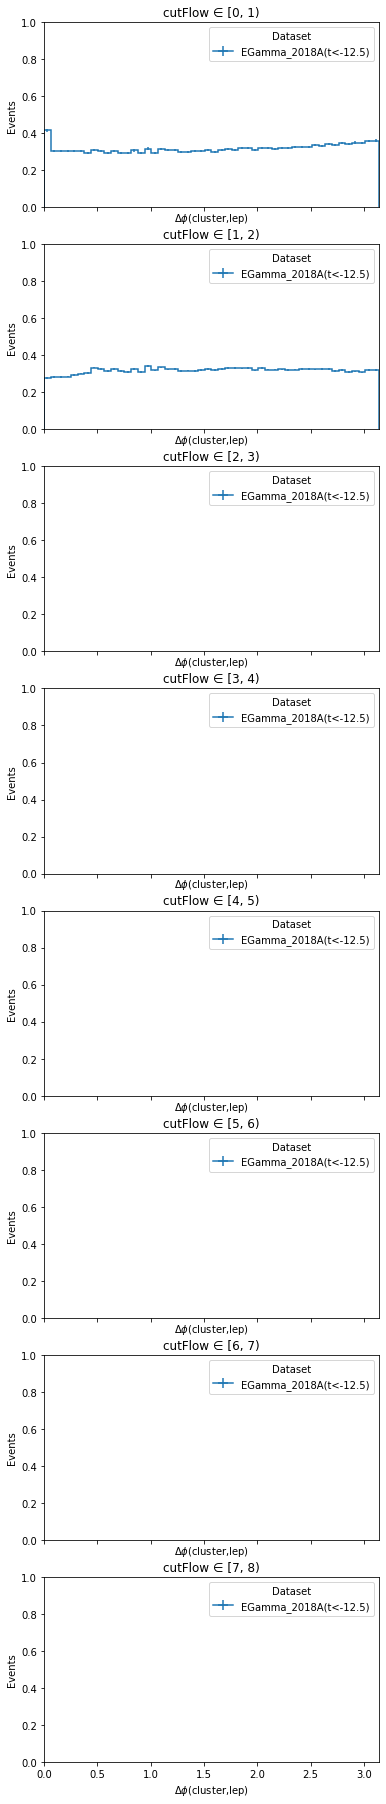

In [4]:
h = out['dphi_cluster_lep'].project("dphi",'dataset','cutFlow')[:1]
axs = hist.plotgrid(h,row='cutFlow',overlay='dataset',density=True)
for ax in axs.flatten():
    ax.set_ylim(0,1)

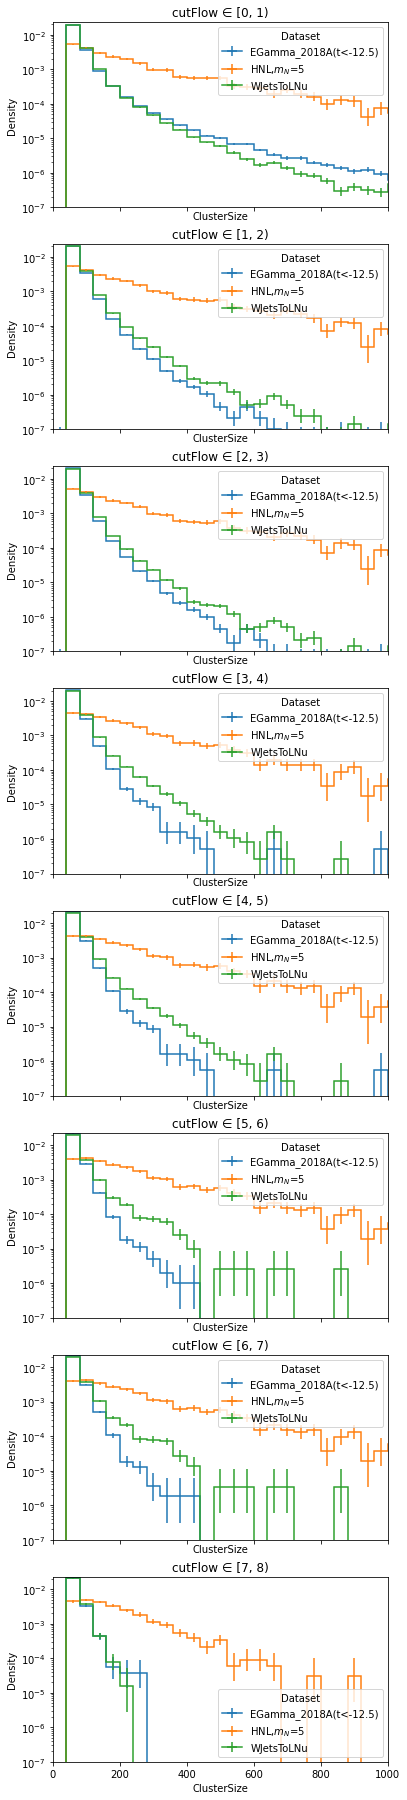

In [121]:
h = out['ClusterSize']
h.label="Density"
axs = hist.plotgrid(h,row='cutFlow',overlay='dataset',density=True)
for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_ylim(1e-7,None)
    ax.set_xlim(0,1000)

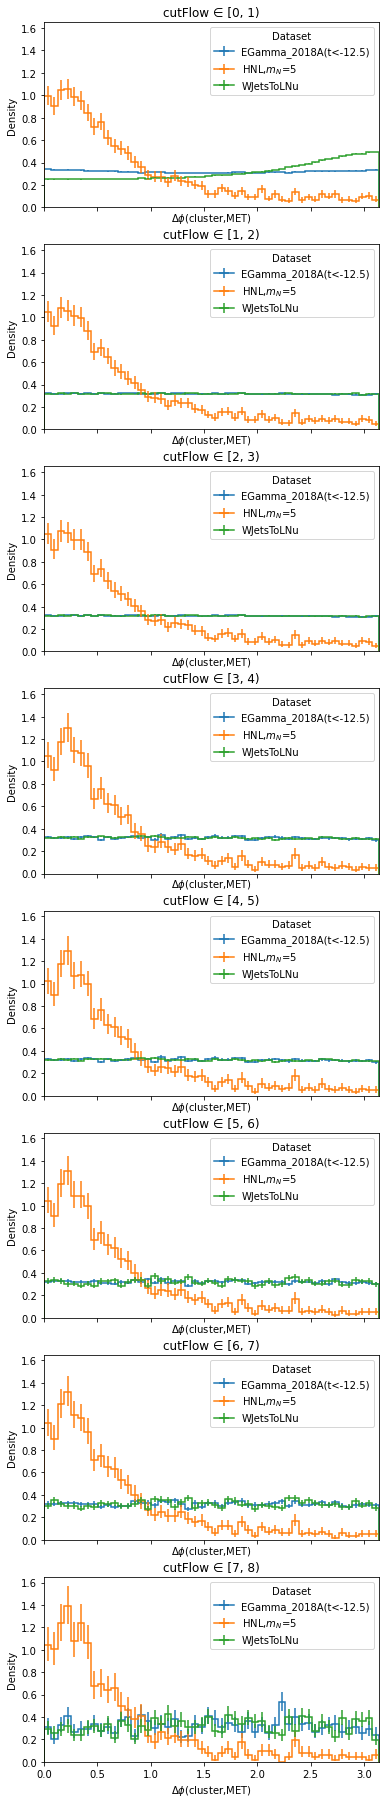

In [116]:
h = out['dphi_cluster_MET']
h.label='Density'
axs = hist.plotgrid(h,row='cutFlow',overlay='dataset',density=True)

WJetsToLNu [1107183.  713644.  707167.   92650.   91682.    9919.    7354.    1557.]
[100.    64.46  63.87   8.37   8.28   0.9    0.66   0.14]
EGamma_2018A(t<-12.5) [942422. 714478. 711436.  47074.  46610.  24629.  13782.   1321.]
[100.    75.81  75.49   5.     4.95   2.61   1.46   0.14]
HNL,$m_N$=5 [2345. 2105. 2048. 1411. 1359. 1330. 1304.  825.]
[100.    89.77  87.33  60.17  57.95  56.72  55.61  35.18]


<AxesSubplot:xlabel='cutFlow', ylabel='Efficiency'>

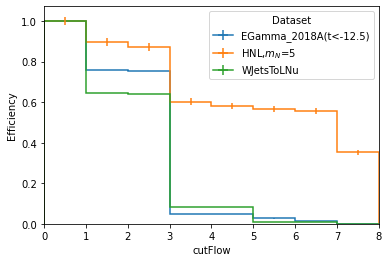

In [124]:
h = out['ClusterSize'].project('cutFlow','dataset')
h.label="Efficiency"
norm = {}
for d,cutflow in h.values().items():
    norm[d[0]]=1./cutflow[0]
    print(d[0],cutflow)
    print(np.round(cutflow/cutflow[0]*100,2))
h.scale(norm, "dataset")    
hist.plot1d(h,overlay='dataset')

WJetsToLNu [345086. 318095.      0.      0.      0.      0.      0.      0.]
[100.    92.18   0.     0.     0.     0.     0.     0.  ]
EGamma_2018A(t<-12.5) [159439. 289756.      0.      0.      0.      0.      0.      0.]
[100.   181.73   0.     0.     0.     0.     0.     0.  ]
HNL,$m_N$=5 [354. 347. 296. 220. 215. 214. 213. 144.]
[100.    98.02  83.62  62.15  60.73  60.45  60.17  40.68]


<AxesSubplot:xlabel='cutFlow', ylabel='Efficiency'>

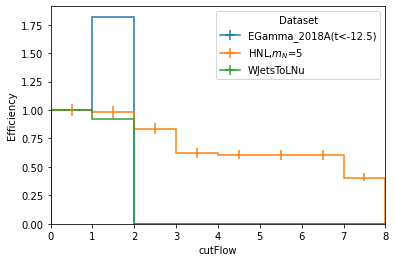

In [101]:
h = out['dphi_cluster_lep'].project('cutFlow','dataset')
h.label="Efficiency"
norm = {}
for d,cutflow in h.values().items():
    norm[d[0]]=1./cutflow[0]
    print(d[0],cutflow)
    print(np.round(cutflow/cutflow[0]*100,2))
h.scale(norm, "dataset")    
hist.plot1d(h,overlay='dataset')

In [6]:
with open('HNL_histograms_May13.pickle','wb') as f:
    pickle.dump(out,f)

In [2]:
# with open('HNL_histograms.pickle','rb') as f:
# with open('HNL_histograms_full_2017B_WJet.pickle','rb') as f:
with open('../HNL_histograms_May13.pickle','rb') as f:
    out = pickle.load(f)

In [3]:
out['sumw']

defaultdict_accumulator(float,
                        {'WJetsToLNu': 22389133.0,
                         'EGamma_2018A(t<-12.5)': 22198219.0,
                         'HNL,$m_N$=5': 4416.0})

In [ ]:
out['sumw']['WJetsToLNu']

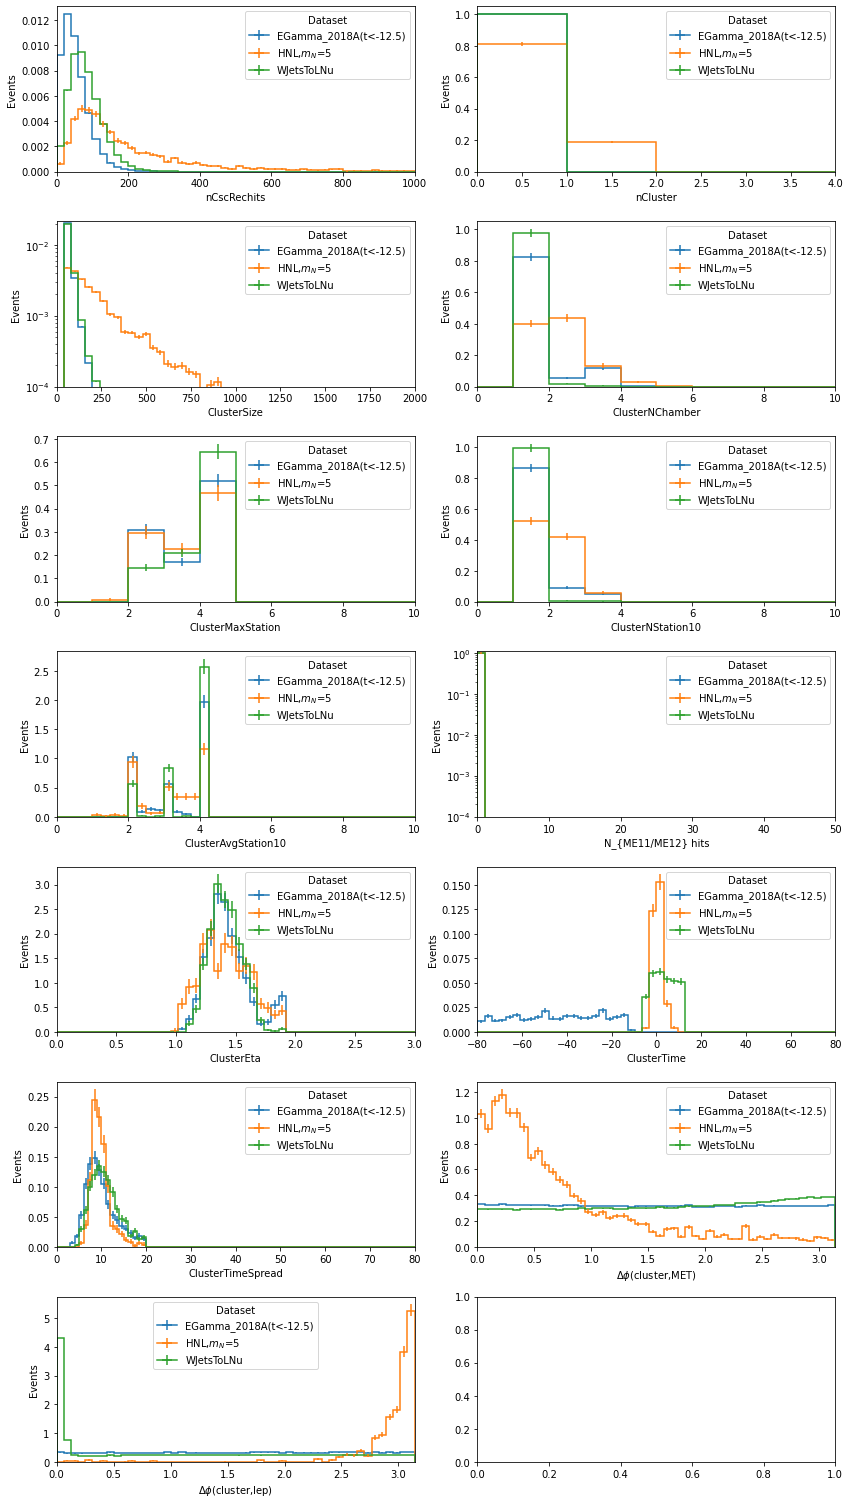

In [94]:
hists = [
    out["nCscRechits"],
    out["nCluster"],
    out['ClusterSize'].project('ClusterSize','dataset'),
    out['ClusterNChamber'],
#     out['ClusterMaxChamber'],
    out['ClusterMaxStation'],
    out['ClusterNStation10'],
    out['ClusterAvgStation10'],
    out['ClusterME11_ME12'],    
    out['ClusterEta'],    
    out['ClusterTime'],
    out['ClusterTimeSpread'],
    out['dphi_cluster_MET'].project("dphi_cluster_MET","dataset"),
    out['dphi_cluster_lep'].project('dphi','dataset')
]

ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

# lumi = 4.321
# br = 0.3
# xsec = 56000*1000 *br
# nevts_WJ = out['sumw']['WJetsToLNu']
# nevts_data = out['sumw']['SingleMu 2017B(t<-12.5)']

# print('nevts_WJ = ',nevts_WJ )
# print('nevts_data = ',nevts_data )
# print('weight = ',lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
#     h.label='Density'
#     hplot = h.copy()
#     hplot.scale({"WJetsToLNu": lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ}, "dataset")    
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)

axs[2].set_ylim(1e-4,None);axs[2].set_yscale('log')    
# axs[8].set_ylim(1e-4,None);axs[8].set_yscale('log')    

axs[7].set_ylim(1e-4,None);axs[7].set_yscale('log')        

plt.tight_layout()
plt.show()

In [ ]:
h=out['clusterID']
ncols=2
nrows=2
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

hist.plot2d(h[r'HNL,$m_N$=5'].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[0])
hist.plot2d(h["SingleMu 2017B(t<-12.5)"].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[1])
hist.plot2d(h["WJetstoLNu"].project("Eta","AvgStation10"),xaxis='Eta',ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
h[r'HNL,$m_N$=5']

In [ ]:
v = out['Veto']
h = out['muVeto']
j = out['jetVeto']
ncols=2
nrows=4
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

h.label='Density'

hist.plot2d(h['SingleMu 2017B(t<-12.5)'].project("time","pt"),xaxis='time',ax=axs[0])

# for i,name in enumerate(['muVeto','jetVeto']):
#     hist.plot1d(v.project(name,'dataset'),ax=axs[i], overlay='dataset',density=True,clear=False)

# for i,name in enumerate(['pt','time','eta','LooseId','LooseIso']):
for i,name in enumerate(['pt','time','eta']):
    hist.plot1d(h.project(name,'dataset'),ax=axs[i+1], overlay='dataset',density=True,clear=False)

# for i,name in enumerate(['pt','eta']):
#     hist.plot1d(j.project(name,'dataset'),ax=axs[i+5], overlay='dataset',density=True,clear=False)

# axs[-2].set_xlabel('jetVeto_pt')    
# axs[-1].set_xlabel('jetVeto_eta')    
    
# axs[2].set_ylim(1E-4,10);axs[2].set_yscale('log')
# axs[3].set_ylim(1E-4,10);axs[3].set_yscale('log')
plt.tight_layout()
plt.show()

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:44: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:299: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/mplhep/plot.py:302: RuntimeWarning: invalid value encountered in multiply
  _yerr_lo[i] = _yerr_lo[i] * density_arr[i]
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/s

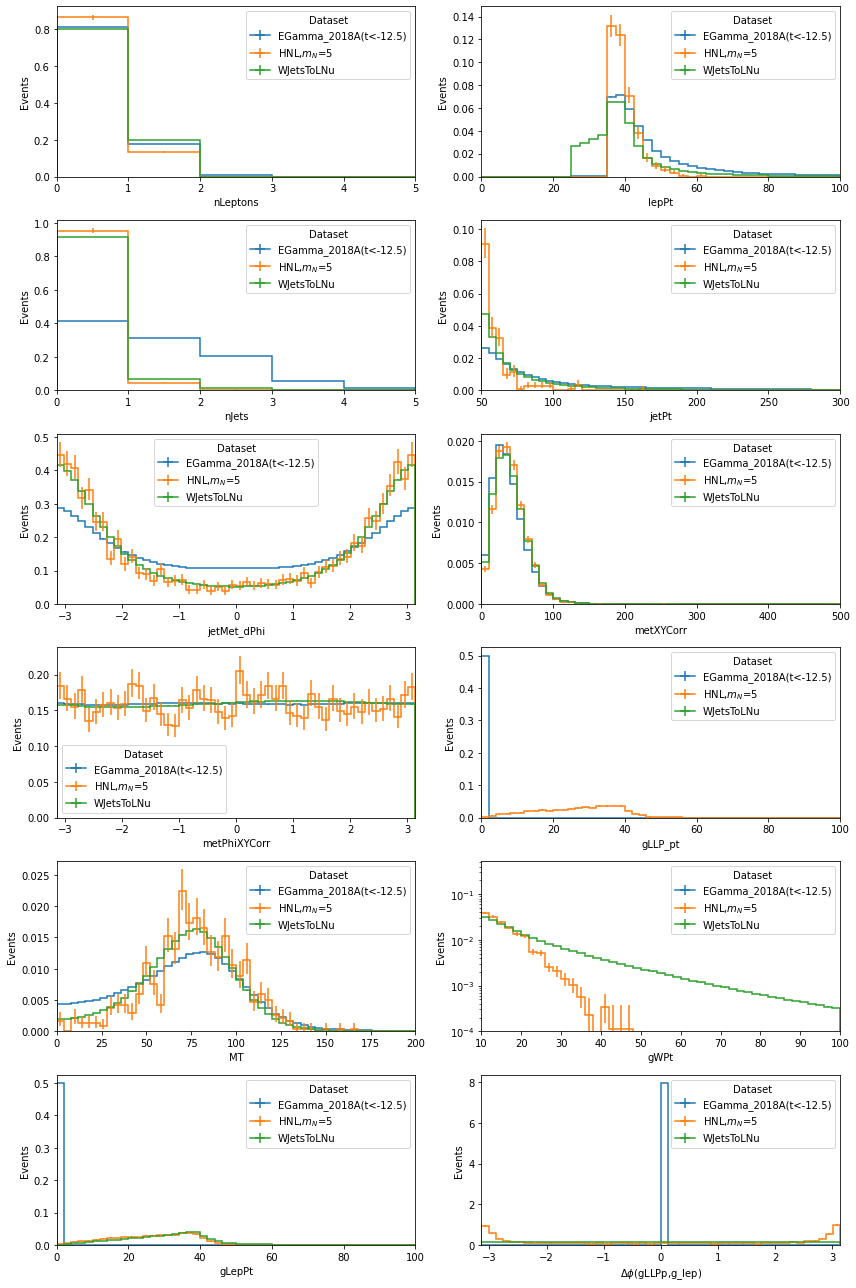

In [96]:
hists = [
    out["nLeptons"],
    out["lepPt"],
    out['nJets'],
    out['jetPt'],
    out['jetMet_dPhi'],    
    out['metXYCorr'],
    out['metPhiXYCorr'],  
    out['gLLP_pt'],
    out['MT'],    
    out['gWPt'],     
    out['gLepPt'],         
    out['glepdPhi'],             
]


ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
#     h.label='Density'
#     h.scale(, "dataset")    
#     hplot = h.copy()
#     hplot.scale({"WJetsToLNu": lumi *(nevts_data / 4586253.0)* xsec / nevts_WJ}, "dataset")    
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)
# axs[1].set_ylim(1e3,1e7);axs[1].set_yscale('log')    
# axs[3].set_ylim(1,1e7);axs[3].set_yscale('log')
axs[9].set_ylim(1e-4,None);axs[9].set_yscale('log');axs[9].set_xlim(10,None)
# axs[4].set_ylim(1e-4,None)
# axs[4].set_yscale('log')
# axs[-3].set_ylim(1e-4,None)
# axs[-3].set_yscale('log')
plt.tight_layout()

h = out["gLLP_csc"]
ax = hist.plot1d(h, overlay='dataset',density=True,clear=False)
print("Efficiency in CSC:")
for ds,arr in h.values().items():
    print(ds,"{:.3f}".format(arr[1]/np.sum(arr)))

In [ ]:
h = out['dphi_cluster_lep']
hist.plotgrid(
    h,
    col='llp_matched',
    overlay='dataset',
    density=True,
)

In [ ]:
import matplotlib.patches as patches

def plotEff_efrac(h,ax,axis='e'):
    h_pass=h.integrate('selection',slice(1,None))
    h_pass.label='Signal Efficiency'

    h_EMfrac_p9=h.integrate("EMfrac",slice(0.5,None))
    h_EMfrac_p9_pass=h_EMfrac_p9.integrate("selection",slice(1,None))
    h_EMfrac_p9_pass.label='Signal Efficiency'
    
    h_EMfrac_low=h.integrate("EMfrac",slice(None,0.5))
    h_EMfrac_low_pass=h_EMfrac_low.integrate("selection",slice(1,None))
    h_EMfrac_low_pass.label='Signal Efficiency'
    
    hist.plotratio(
    ax=ax,
    num=h_pass.project(axis),
    denom=h.project(axis),
    error_opts={ 'marker': '.'},
    unc='clopper-pearson',
    label='Inclusive'
    )

    hist.plotratio(
        ax=ax,
        num=h_EMfrac_p9_pass.project(axis),
        denom=h_EMfrac_p9.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac>0.5'
    )
    hist.plotratio(
        ax=ax,
        num=h_EMfrac_low_pass.project(axis),
        denom=h_EMfrac_low.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac<0.5'
    )    
    ax.legend(loc='best')
    return ax

def plotEff(h_list,ax,axis='e'):
    for h in h_list:
        h_pass=h.integrate('selection',slice(1,None))
        h_pass.label='Signal Efficiency'
        
        hist.plotratio(
            ax=ax,
            num=h_pass.project(axis),
            denom=h.project(axis),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label=h.identifiers('dataset')[0].name,
            clear=False
        )

    ax.legend(loc='best')
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-110 ,y_max*0.05, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.05, "Outer ring", fontsize=15)
    return ax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

In [ ]:
h=out['llp'][2:]

ncols=2
nrows=4
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs=axs.flatten()

for i,d in enumerate(['selection','e','EMfrac','z','r']):
    hist.plot1d(h.project(d,'dataset'),ax=axs[i],overlay="dataset",density=True)

plotEff_efrac(         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5'],axs[5],'z')    
    
axs[5] = drawCSCz(axs[5])    
# plotEff([         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#          h[r'HNL,$m_N$=5'],                  
#          ],axs[5],'e')
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[6],'z')
# axs[6].set_ylim(0,2)
# axs[6] = drawCSCz(axs[6])
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[7],'r')
# axs[7] = drawCSCr(axs[7])
plt.tight_layout()

In [ ]:

h=out['llp']

ncols=1
nrows=1
figsize=(6,3)

fig, ax = plt.subplots(figsize=figsize)


plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5'],         
         ],ax,'EMfrac')
# ax=drawCSCz(ax)
ax.legend(loc=1)

plt.tight_layout()

In [ ]:
h.identifiers("dataset")

In [ ]:
for i in h:
    print(i.identifiers("dataset"))

In [ ]:
h_HNL.sparse_axes()

In [ ]:
#'clusterDecay': <Hist (dataset,length,llp_z,cluster_z) instance at 0x7f3ee4304a90>,

h = out['clusterDecay']

l =out['llp']



ncols=2
nrows=3
figsize=(6,4)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs=axs.flatten()


h_higgs = h[r'$m_s$=15,$c\tau$=1m']
h_HNL    =h[r'HNL,$m_N$=5']

for i,histo in enumerate([h_higgs,h_HNL]):
    hist.plot2d(histo.project('llp_z',"cluster_z"),xaxis='llp_z',ax=axs[2*i])
    hist.plot2d(histo.project('llp_z',"length"),xaxis='llp_z'   ,ax=axs[2*i+1])
    drawCSCsteel(axs[2*i])
    drawCSCsteel(axs[2*i+1])    
    
def drawCSCsteel(ax,hORv='v'): 
    y_max = ax.get_zlim()[1]
    if hORv=='v':
        ax.axvline(632);ax.axvline(632+39)
        ax.axvline(724);ax.axvline(724+64)
        ax.axvline(849);ax.axvline(849+62)
        ax.axvline(970);ax.axvline(970+32)
    else:
        ax.axhline(632);ax.axhline(632+39)
        ax.axhline(724);ax.axhline(724+64)
        ax.axhline(849);ax.axhline(849+62)
        ax.axhline(970);ax.axhline(970+32)   
        
    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)        
    return 
        
# hist.plot1d(h_HNL.project("length",'dataset'),ax=axs[4],overlay="dataset")    
# hist.plot1d(h_higgs.project("length",'dataset'),ax=axs[5],overlay="dataset")    

plotEff([l[r'$m_s$=15,$c\tau$=1m']],axs[4],'z')    
axs[4] = drawCSCz(axs[4])    

plotEff([l[r'HNL,$m_N$=5']],axs[5],'z')    
axs[5] = drawCSCz(axs[5])    

    
plt.tight_layout()